In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [2]:
from urllib.error import URLError, HTTPError
from urllib.request import urlopen
from scipy.io import loadmat


def fetch_file(url):
    """Downloads a file from a URL.
    """
    try:
        f = urlopen(url)
        print("Downloading data file " + url + " ...")

        # Open our local file for writing
        with open(os.path.basename(url), "wb") as local_file:
            local_file.write(f.read())
        print("Done.")

    #handle errors
    except HTTPError as e:
        print("HTTP Error:", e.code, url)
    except URLError as e:
        print("URL Error:", e.reason, url) 
        
url =  "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
data_filename = os.path.basename(url)
if not os.path.exists(data_filename):
    fetch_file(url)
else:
    print("Data file %s exists." % data_filename) 
    
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = loadmat(data_filename, squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, img_rows, img_cols))

Data file frey_rawface.mat exists.


In [3]:
# split data into train / validation folds
np.random.seed(42)
n_pixels = img_rows * img_cols
x_train = ff[:1800]
x_test = ff[1800:1900]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

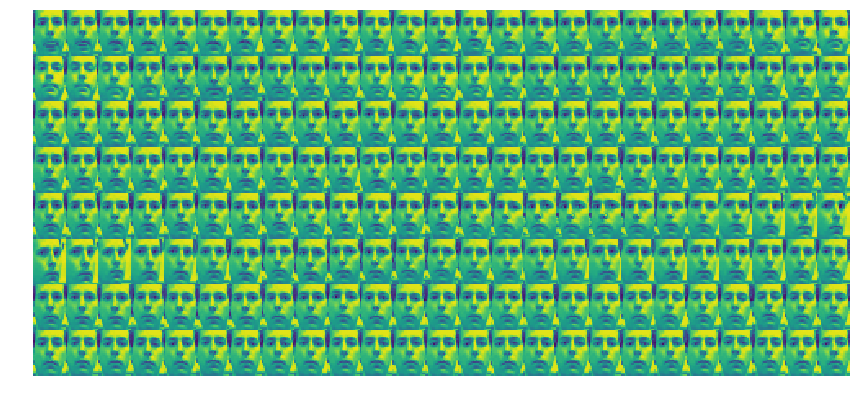

In [4]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=200, n_cols=25)

In [5]:
import tensorflow as tf
sess = tf.Session()

K.set_session(sess)

In [6]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     return z_mean + K.exp(0.5 ) * epsilon

In [7]:

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test = data
    os.makedirs(model_name, exist_ok=True)

    
    
    """filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    """

    filename = os.path.join(model_name, "face_over_latent.png")
    n = 10
    digit_size = 28
    img_rows, img_cols = 28, 20
    figure = np.zeros((img_rows * n, img_cols * n))
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_rows, img_cols)
            figure[i * img_rows: (i + 1) * img_rows,
                   j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(10, 10))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [8]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 256
intermediate_dim2 = 64
intermediate_dim3 = 16

batch_size = 128
latent_dim = 2
epochs = 50

In [9]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x1)
x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x3)
z_log_var = Dense(latent_dim, name='z_log_var')(x3)


In [10]:
# standardize the mean of z, so that mean(m_z)=0 and cov(m_z)=I
def standardize(z_mean):
    z_m_m = K.mean(z_mean,axis=0, keepdims=True)
    z1 = z_mean - z_m_m
    n = tf.cast(K.shape(z_mean)[0], tf.float32)
    cov = K.transpose(z1) @ z1 /n
    
    D = tf.diag(tf.diag_part(cov)) ** 0.5
    
    L = tf.linalg.inv(tf.transpose(tf.cholesky(cov)))
       
#     z2 = z1 @ L @ D +  z_m_m
    z2 = z1 @ L  +  z_m_m

    return( z2)

In [11]:
z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

In [12]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean_std, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean_std, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 560)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          143616      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           16448       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           1040        dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [13]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(x2)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_7 (Dense)              (None, 560)               143920    
Total params: 161,696
Trainable params: 161,696
Non-trainable params: 0
_________________________________________________________________


In [14]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [15]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 560)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 161172    
_________________________________________________________________
decoder (Model)              (None, 560)               161696    
Total params: 322,868
Trainable params: 322,868
Non-trainable params: 0
_________________________________________________________________


In [16]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 1800 samples, validate on 100 samples
Epoch 1/50
1800/1800 [==============================] - 1s 504us/step - loss: 378.1007 - val_loss: 365.4559
Epoch 2/50
1800/1800 [==============================] - 0s 87us/step - loss: 357.2801 - val_loss: 362.9323
Epoch 3/50
1800/1800 [==============================] - 0s 91us/step - loss: 353.5753 - val_loss: 362.0562
Epoch 4/50
1800/1800 [==============================] - 0s 92us/step - loss: 351.7747 - val_loss: 360.8721
Epoch 5/50
1800/1800 [==============================] - 0s 90us/step - loss: 350.8093 - val_loss: 362.8789
Epoch 6/50
1800/1800 [==============================] - 0s 88us/step - loss: 350.1632 - val_loss: 361.5761
Epoch 7/50
1800/1800 [==============================] - 0s 91us/step - loss: 349.6968 - val_loss: 360.1610
Epoch 8/50
1800/1800 [==============================] - 0s 91us/step - loss: 349.4700 - val_loss: 360.3251
Epoch 9/50
1800/1800 [==============================] - 0s 88us/step - loss: 349.2656 - val_loss

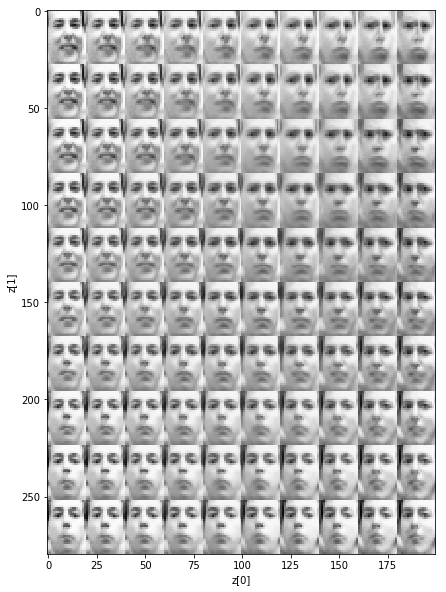

In [17]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

In [18]:
z_output = sess.run( z_mean_std, feed_dict={'encoder_input:0':x_test})

In [19]:
np.mean(z_output,axis=0)

array([-0.06362124,  0.06969009], dtype=float32)

In [20]:
np.cov(z_output.T)

array([[1.01010084e+00, 1.67974467e-07],
       [1.67974467e-07, 1.01010115e+00]])